# Analysis

Let's look at one particular example of the CORD dataset.

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


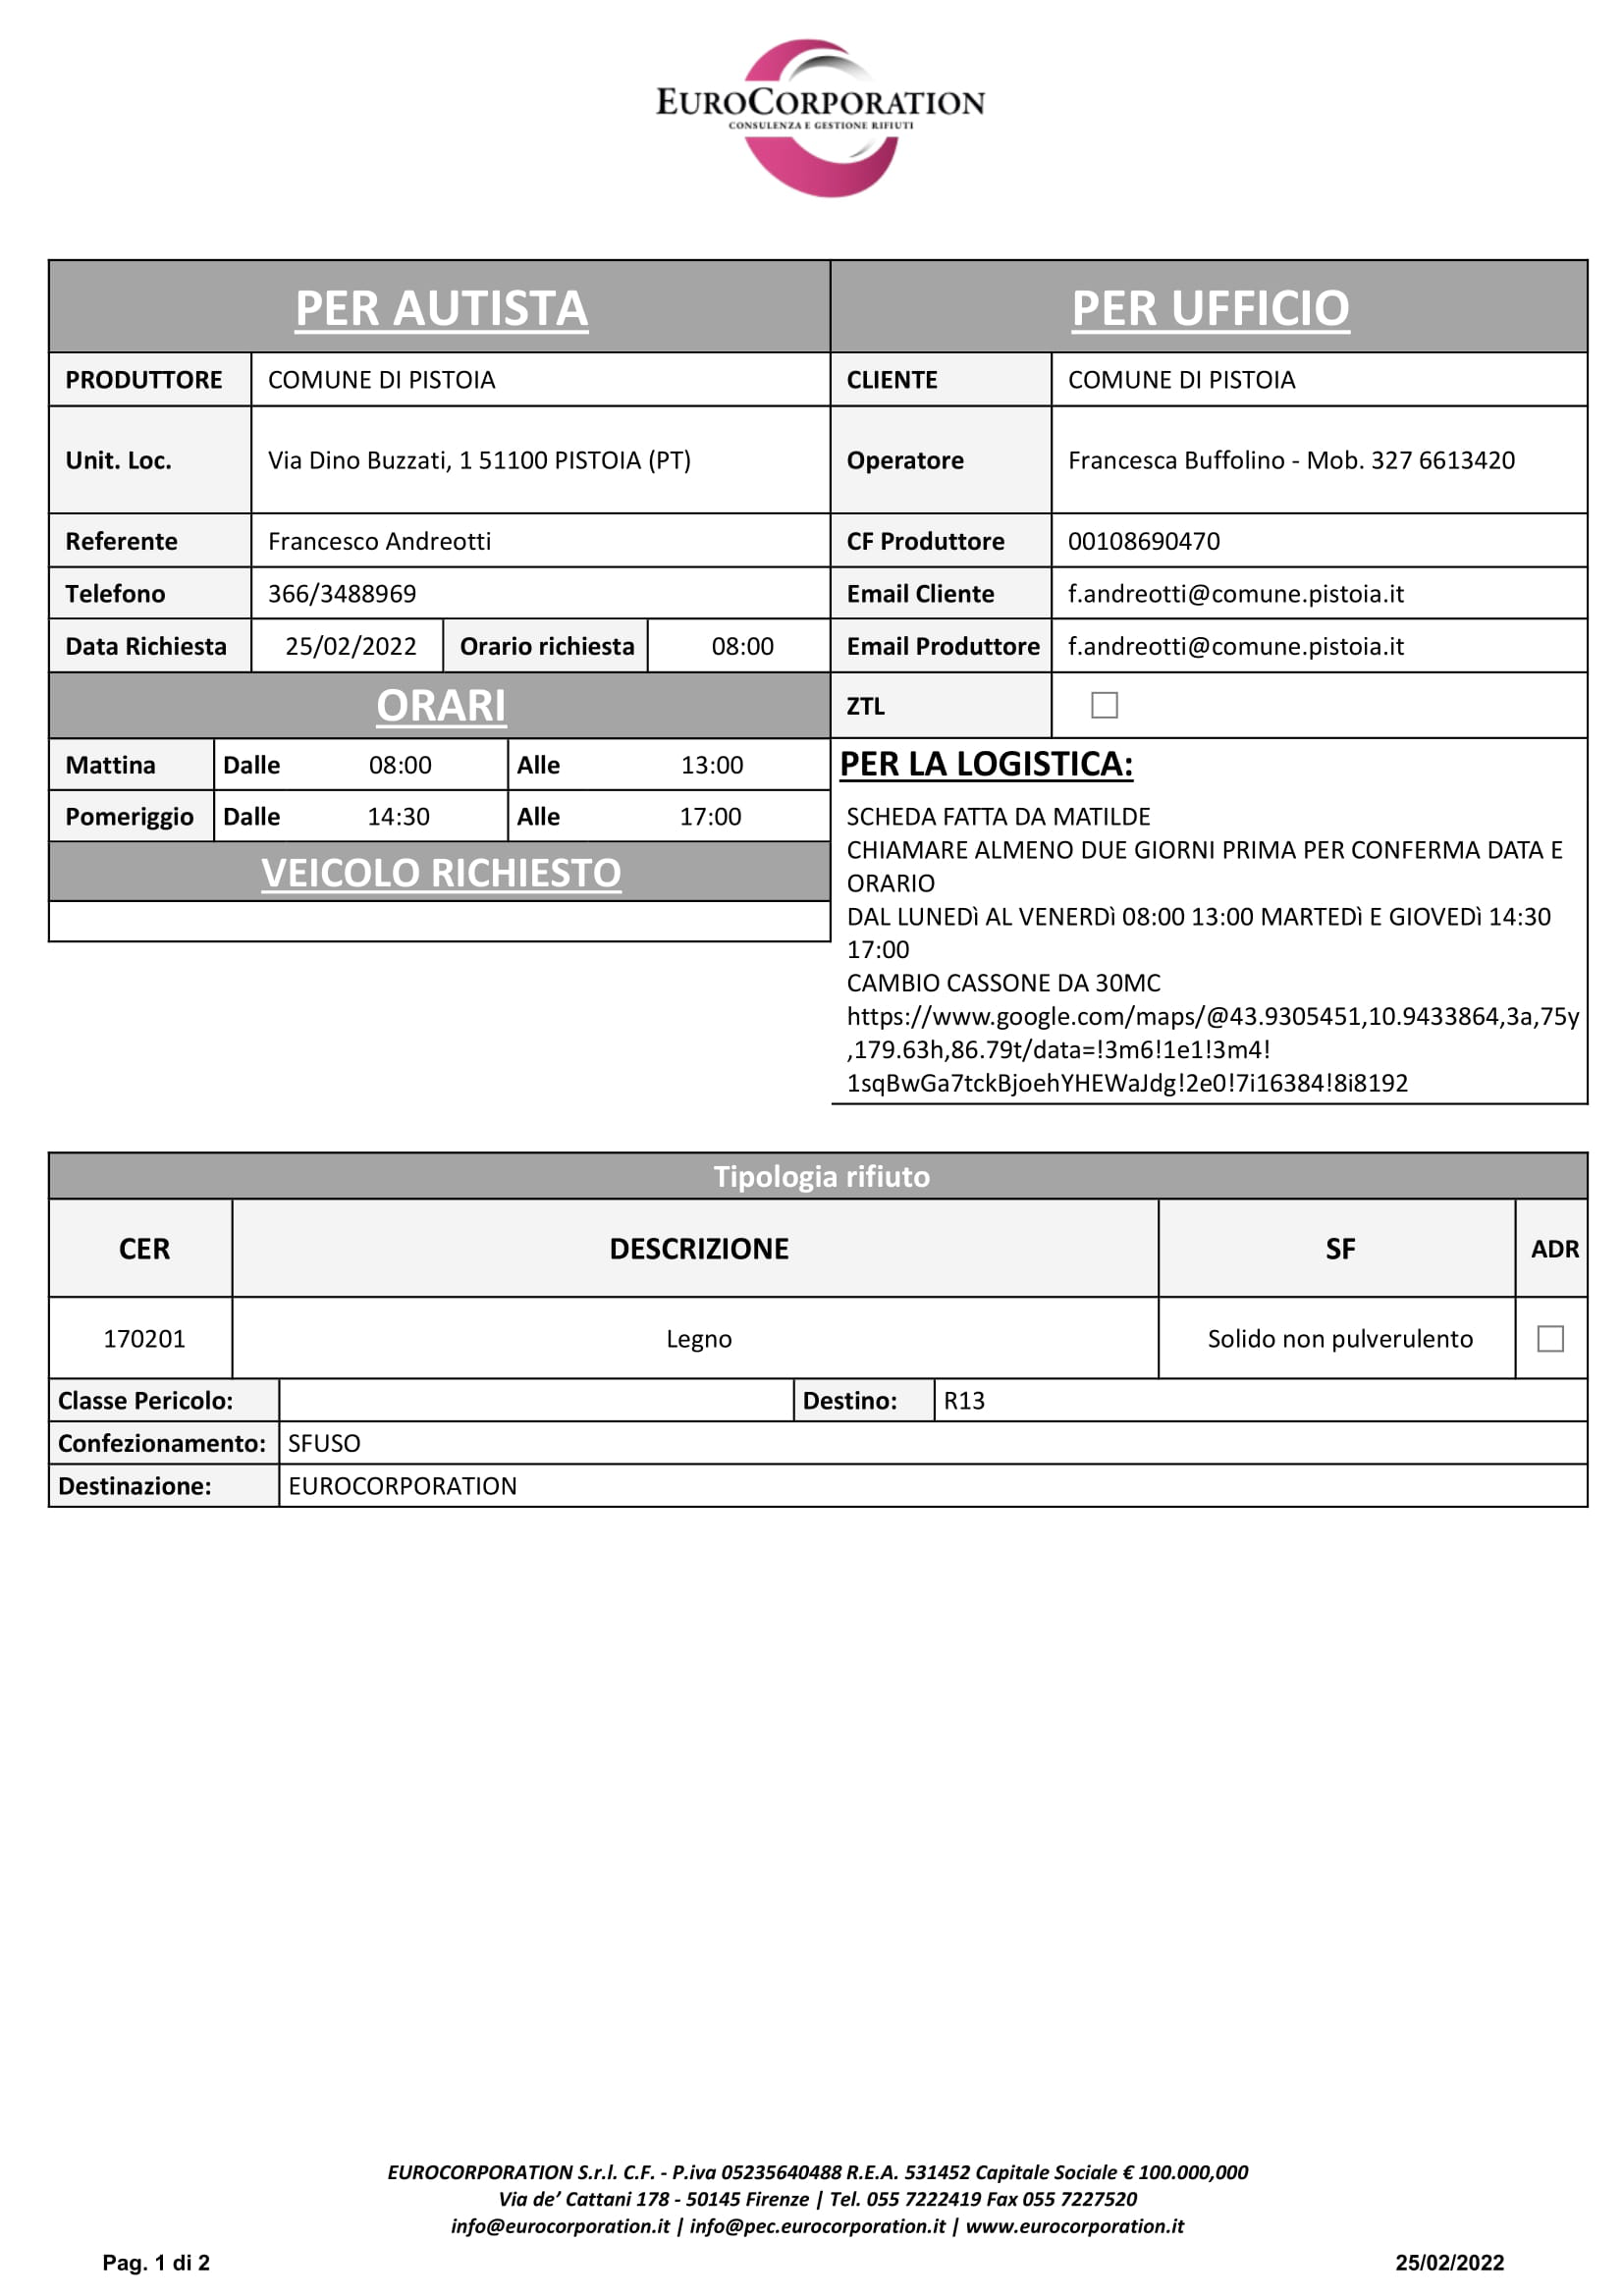

In [254]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/images/test/10.jpg')
image

Let's read in the corresponding OCR annotations.

In [255]:
import json

with open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/test/10.json') as json_file:
    data = json.load(json_file)

In [256]:
data.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [257]:
data['meta']

{'image_id': 7,
 'image_size': {'height': 2339, 'width': 1653},
 'split': 'train',
 'version': 'v0.1'}

In [258]:
data['roi']

{}

In [259]:
data['repeating_symbol']

[]

This particular example has 93 OCR annotations:

In [260]:
len(data['valid_line'])

41

Let's look at the first one:

In [261]:
data['valid_line'][0]

{'category': 'header',
 'words': [{'quad': {'x1': 1020,
    'x2': 27,
    'x3': 646,
    'x4': 646,
    'y1': 27,
    'y2': 1020,
    'y3': 208,
    'y4': 208},
   'text': '&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL'}]}

Let's annotate the image with the corresponding bounding boxes:

In [262]:
# import matplotlib.pyplot as mpimg
# import numpy as np
# import matplotlib.pyplot as plt

# #[265, 428, 72, 463][265, 428, 72, 463]
# from matplotlib.pyplot import figure

# figure(figsize=(50, 50), dpi=80)

# image = mpimg.imread("/content/data4/1.png")
# pts = np.array([[72,428],[265,468]])

# plt.imshow(image)
# plt.plot(640, 570, "og", markersize=10)  # og:shorthand for green circle
# plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)
# plt.show()

In [263]:
import random

labels = ['question','answer','header','other']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

['#cbfd9b', '#8c4087', '#ae530d', '#69e395']


[646, 27, 1020, 208]
[291, 284, 610, 347]
[1078, 282, 1383, 345]
[59, 369, 239, 401]
[269, 373, 510, 402]
[57, 448, 190, 489]
[267, 456, 709, 486]
[57, 529, 200, 571]
[262, 533, 531, 569]
[57, 585, 200, 621]
[263, 586, 428, 620]
[59, 640, 240, 676]
[283, 642, 434, 674]
[459, 636, 654, 677]
[459, 636, 654, 677]
[714, 643, 795, 671]
[854, 361, 979, 406]
[1082, 365, 1595, 405]
[851, 439, 1000, 493]
[1077, 441, 1520, 499]
[857, 532, 1033, 568]
[1073, 526, 1331, 564]
[851, 582, 1030, 624]
[1080, 582, 1512, 620]
[851, 636, 1066, 678]
[1077, 638, 1516, 676]
[361, 690, 549, 753]
[61, 758, 170, 799]
[224, 756, 805, 797]
[61, 815, 201, 849]
[222, 812, 808, 850]
[247, 862, 645, 916]
[711, 1177, 965, 1222]
[93, 1245, 195, 1293]
[87, 1341, 203, 1383]
[851, 758, 1165, 805]
[854, 806, 1619, 1120]
[855, 811, 1602, 1187]
[383, 2188, 1283, 2288]
[91, 2283, 231, 2322]
[1408, 2283, 1546, 2324]


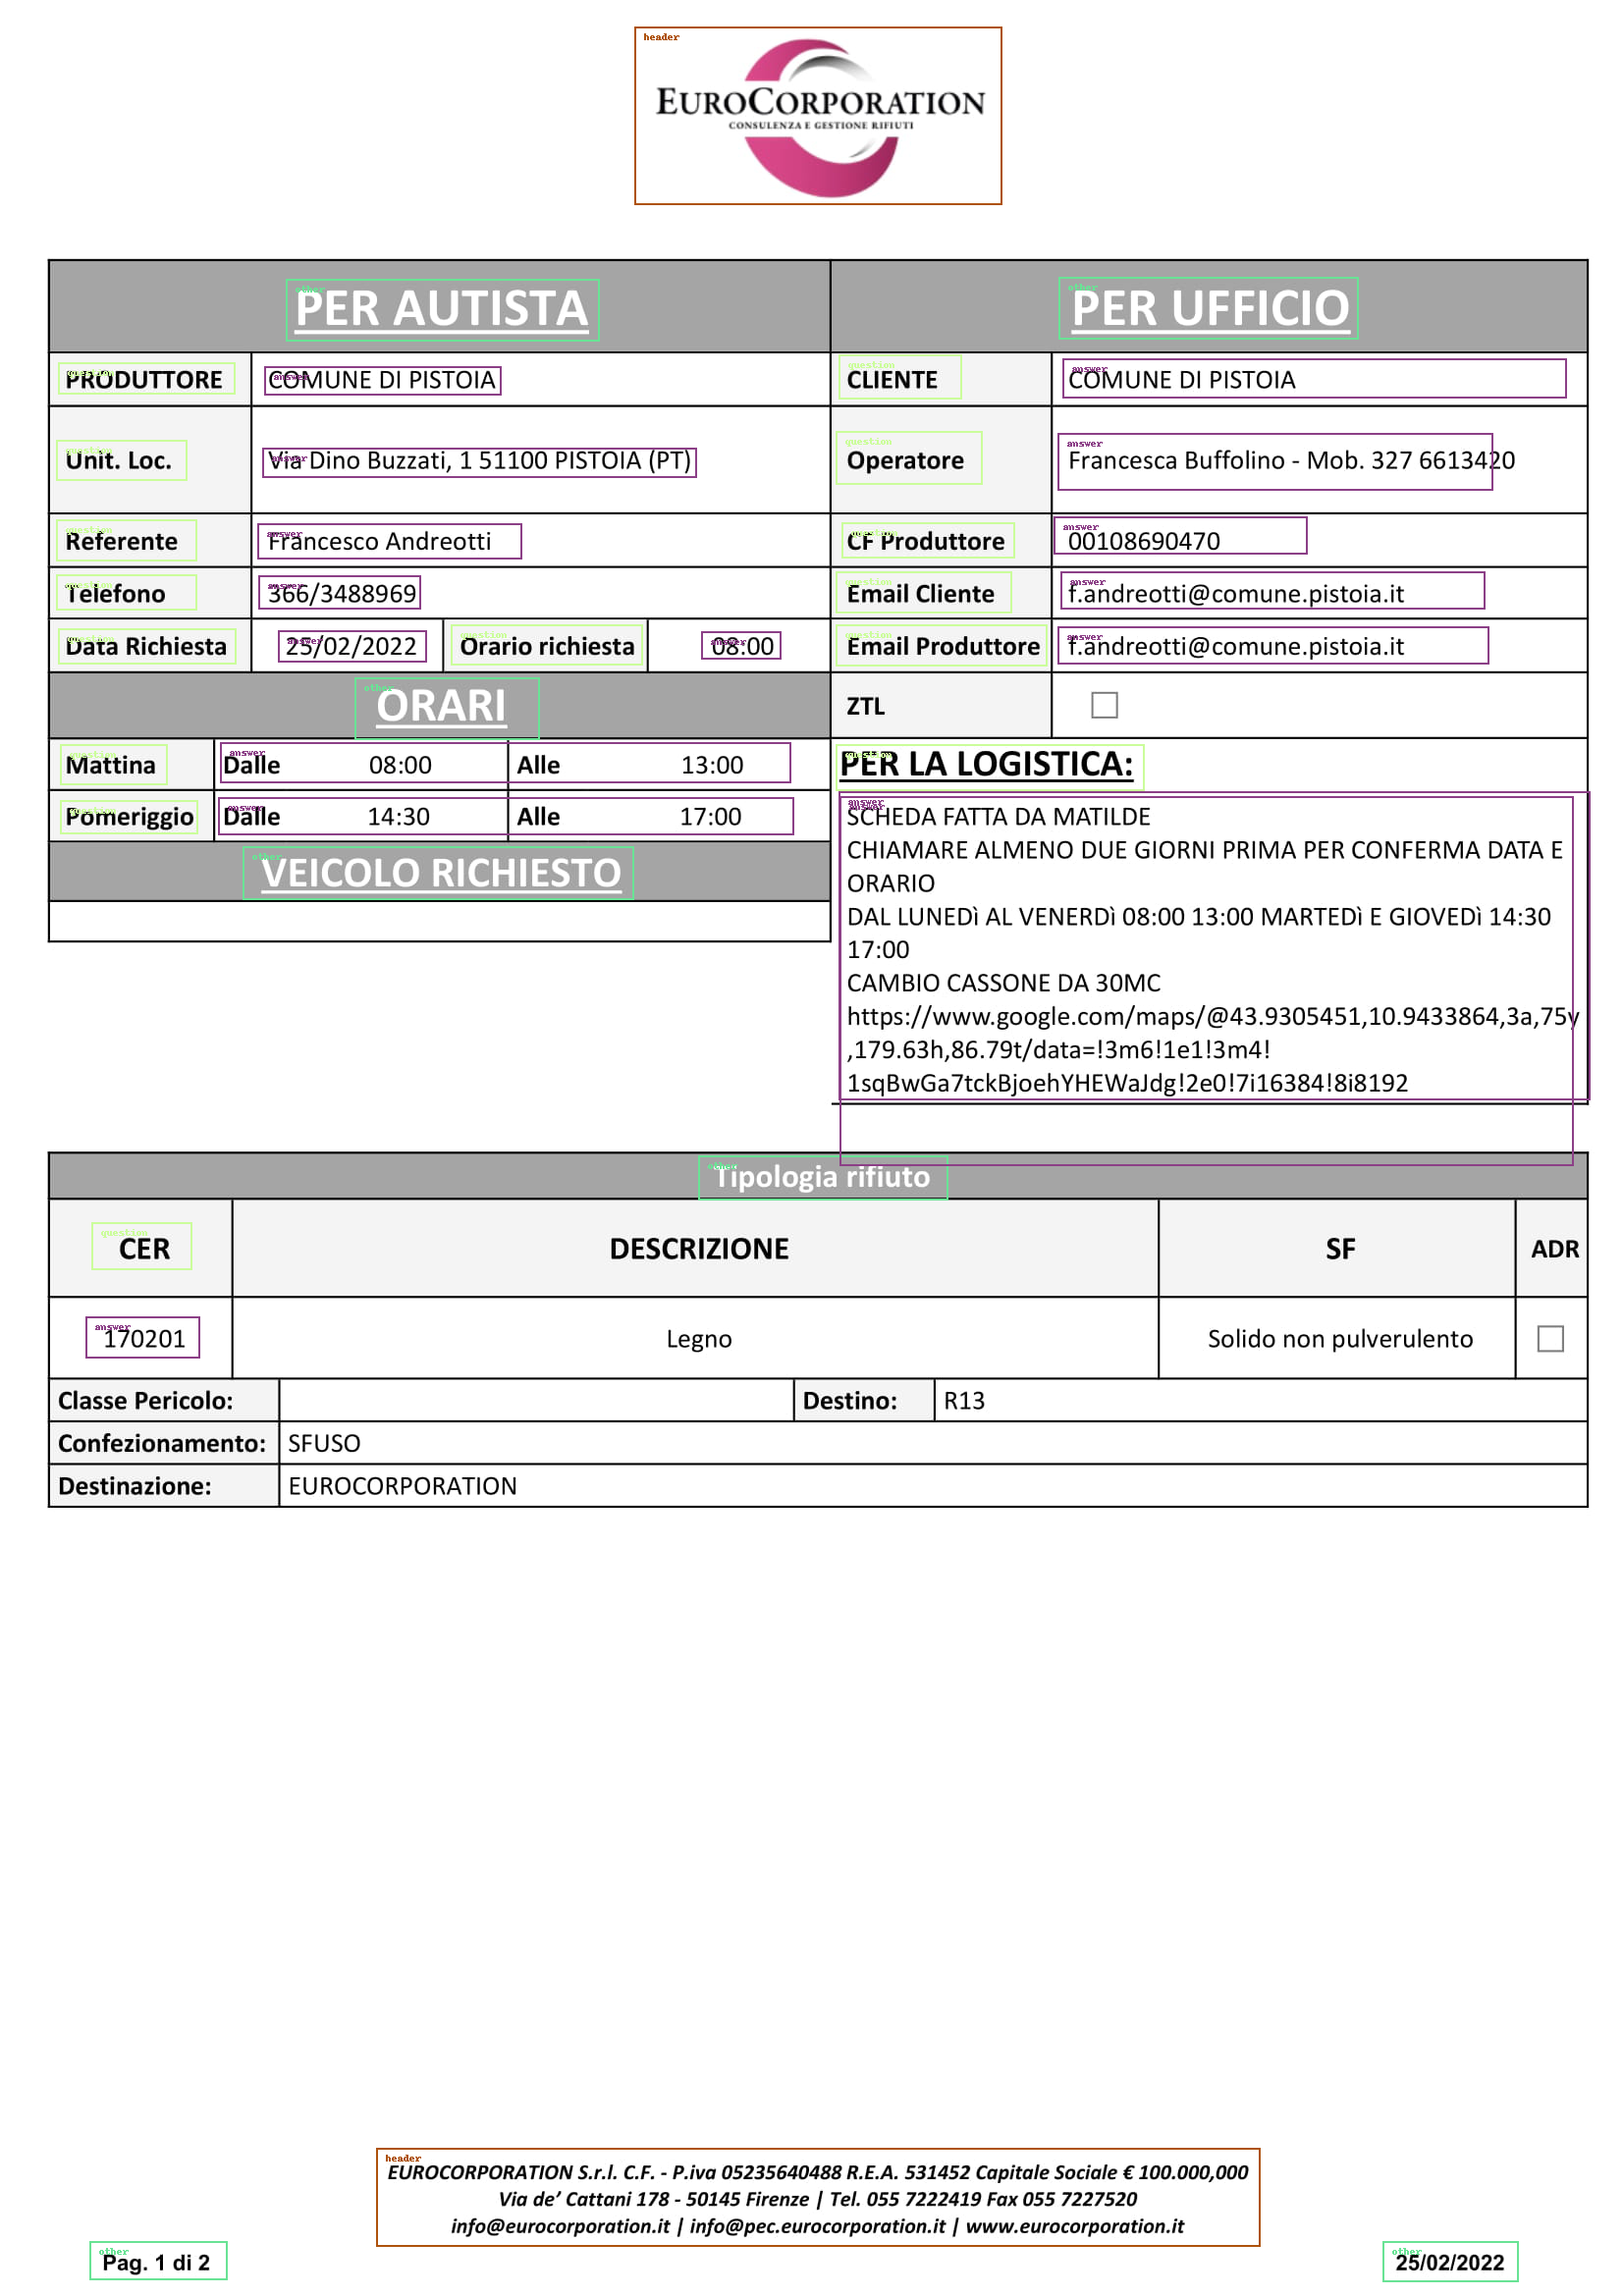

In [264]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
  label = annotation['category']
  words = annotation['words']
  for word in words:
    coordinates = word['quad']
    x1, y1 = coordinates['x1'], coordinates['y1']
    x3, y3 = coordinates['x3'], coordinates['y3']
    box = [x3, y1, x1, y3]
    
    print(box)
    draw.rectangle(box, outline=label2color[label], width=2)
    draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image

# Generating the dataset

In [265]:
from tqdm.notebook import tqdm
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  for js in tqdm(os.listdir(path)):
    with open(path + js) as f:
        annotation_files.append(json.load(f))
  
  words = []
  boxes = []
  labels = []
  for js in tqdm(annotation_files):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']
              
              box = [x3, y1, x1, y3]
              box = normalize_bbox(box, width=width, height=height)

              # ADDED
              # skip empty word
              if len(txt) < 1: 
                continue
              if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
                continue
              if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
                continue
              # ADDED

              words_example.append(txt)
              boxes_example.append(box) 
              labels_example.append(elem['category'])
      words.append(words_example) 
      boxes.append(boxes_example)
      labels.append(labels_example)
  
  return words, boxes, labels

Let's apply the function above for the training, validation and test set:

In [266]:
train_path = '/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/train/'
val_path = '/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/val/'
test_path = '/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/JSON/test/'

words_train, boxes_train, labels_train = generate_annotations(train_path)
words_val, boxes_val, labels_val = generate_annotations(val_path)
words_test, boxes_test, labels_test = generate_annotations(test_path)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [267]:
labels_train

[['header',
  'other',
  'other',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'other',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'other',
  'other',
  'question',
  'answer',
  'question',
  'answer',
  'header',
  'other',
  'other'],
 ['header',
  'other',
  'other',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'other',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'question',
  'answer',
  'other',
  'other',
  'question',
  'answer',
  'question',
  'answer',
  'header',
  'other',
  'other'],
 ['header',
  'o

In [268]:
words_train

[['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
  'PER AUTISTA',
  'PER UFFICIO',
  'PRODUTTORE',
  'D&D Costruzioni SRL',
  'CLIENTE',
  'D&D Costruzioni SRL',
  'Operatore',
  'Mario Nobile - Mob. 3381558401',
  'CF Produttore',
  '06725110487',
  'Email Cliente',
  'info@ddcostruzioni.net',
  'Email Produttore',
  'info@ddcostruzioni.net',
  'ORARI',
  'UnitLoc.',
  'PORTA ROMANA - VIA METASTASIO 48 50124 (FI)',
  'Referente',
  'FABRIZIO PIPOLO',
  'Telefono',
  '3357566640',
  'Data Richiesta',
  '23/02/2022',
  'orario richiesta',
  '08:00',
  'Mattina',
  'Dalle 08:00 Alle 12:00',
  'Pomeriggio',
  'Dalle Alle',
  'VEICOLO RICHIESTO',
  'Tipologia rifiuto',
  'CER',
  '170904.1',
  'PER LA LOGISTICA',
  'SCHEDA FATTA DA MATILDE CHIAMARE PER COMUNICARE ORARIO Florec 3200436592 PORTARE A CAMBIO N.5 CASSE VENERDì MATTINA 25.02.2022https://www.google.com/maps/@43.7602578,11.2378078,3a,75y,244.78h,76.14t/data=!3m7!1e1!3m5! 1sd6ERXwcpkiHcDdpt_LkqMA!2e0!6shttps:%2F%  2Fstreetvie

In [269]:
boxes_train

[[[390, 11, 617, 88],
  [176, 121, 369, 148],
  [652, 120, 836, 147],
  [35, 157, 144, 171],
  [163, 158, 309, 171],
  [516, 154, 592, 173],
  [654, 158, 805, 172],
  [514, 187, 604, 210],
  [655, 193, 889, 209],
  [518, 227, 624, 242],
  [654, 228, 756, 243],
  [514, 248, 623, 266],
  [654, 251, 825, 265],
  [514, 271, 644, 289],
  [653, 273, 825, 289],
  [218, 294, 332, 321],
  [34, 191, 114, 209],
  [163, 193, 505, 209],
  [34, 226, 120, 244],
  [159, 227, 286, 243],
  [34, 250, 120, 265],
  [159, 250, 258, 265],
  [35, 273, 145, 289],
  [167, 274, 263, 287],
  [277, 271, 395, 289],
  [430, 273, 480, 288],
  [36, 324, 102, 341],
  [135, 323, 486, 340],
  [36, 348, 121, 362],
  [134, 347, 488, 363],
  [149, 368, 390, 391],
  [429, 548, 577, 564],
  [68, 576, 109, 597],
  [55, 618, 124, 634],
  [514, 324, 704, 344],
  [516, 346, 978, 520],
  [231, 935, 776, 978],
  [55, 976, 139, 992],
  [851, 976, 935, 993]],
 [[390, 11, 617, 88],
  [176, 121, 369, 148],
  [652, 120, 836, 147],
  [35

# Saving

In [270]:
import pickle
with open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
with open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/val.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val], t)
with open('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test], t)

In [271]:
import pandas as pd

train=pd.read_pickle('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/train.pkl')
train

[[['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
   'PER AUTISTA',
   'PER UFFICIO',
   'PRODUTTORE',
   'D&D Costruzioni SRL',
   'CLIENTE',
   'D&D Costruzioni SRL',
   'Operatore',
   'Mario Nobile - Mob. 3381558401',
   'CF Produttore',
   '06725110487',
   'Email Cliente',
   'info@ddcostruzioni.net',
   'Email Produttore',
   'info@ddcostruzioni.net',
   'ORARI',
   'UnitLoc.',
   'PORTA ROMANA - VIA METASTASIO 48 50124 (FI)',
   'Referente',
   'FABRIZIO PIPOLO',
   'Telefono',
   '3357566640',
   'Data Richiesta',
   '23/02/2022',
   'orario richiesta',
   '08:00',
   'Mattina',
   'Dalle 08:00 Alle 12:00',
   'Pomeriggio',
   'Dalle Alle',
   'VEICOLO RICHIESTO',
   'Tipologia rifiuto',
   'CER',
   '170904.1',
   'PER LA LOGISTICA',
   'SCHEDA FATTA DA MATILDE CHIAMARE PER COMUNICARE ORARIO Florec 3200436592 PORTARE A CAMBIO N.5 CASSE VENERDì MATTINA 25.02.2022https://www.google.com/maps/@43.7602578,11.2378078,3a,75y,244.78h,76.14t/data=!3m7!1e1!3m5! 1sd6ERXwcpkiHcDdpt

In [272]:

val=pd.read_pickle('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/val.pkl')
val

[[['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
   'PER AUTISTA',
   'PER UFFICIO',
   'PRODUTTORE',
   'PRINZ B. E F. SRL',
   'UnitLoc.',
   'SAN DONNINO - Via dei Platani , SNC 50013 CAMPI BISENZIO (FI)',
   'Referente',
   'Andrea Piras',
   'Telefono',
   '338/3659970',
   'Mattina',
   'Dalle 08:00 Alle 12:00',
   'Pomeriggio',
   'Dalle 14:00 Alle 16:30',
   'VEICOLO RICHIESTO',
   'Tipologia rifiuto',
   'Data Richiesta',
   '18/02/2022',
   'orario richiesta',
   '10:00',
   'PER LA LOGISTICA',
   'SCHEDA FATTA DA MATILDE.CHIAMARE PER COMUNICARE GIORNO E ORARIO CAMBIO CASSONE 30MC SCOPERTO.NON MANDARE IL MEZZO DURANTE LA PAUSA PRANZO OVVERODALLE 12:00 ALLE 14:00https://www.google.com/maps/@43.795193,11.1376355,3a,75y,180.29h,78.32t/data=!3m6!1e1!3m4!1sEq84VODnctsGtWo_l7ssZg!2e0!7i13312!8i6656',
   'CLIENTE',
   'PRINZ B. E F. SRL',
   'Operatore',
   'Alessandro Barone - Mob. 335/5942201',
   'CF Produttore',
   '05663300480',
   'Email Cliente',
   'sauro.giunchi@prin

In [273]:
test=pd.read_pickle('/content/drive/MyDrive/EuroCoorp/CORDTest/layoutLMV2 -CORD/pickle/test.pkl')
test

[[['&“~ EUROCORPORATION CONSULENZA E GESTIONE RIFLUTL',
   'PER AUTISTA',
   'PER UFFICIO',
   'PRODUTTORE',
   'COMUNE DI PISTOIA',
   'UnitLoc.',
   'Via Dino Buzzati, 1 51100 PISTOIA (PT)',
   'Referente',
   'Francesco Andreotti',
   'Telefono',
   '366/3488969',
   'Data Richiesta',
   '25/02/2022',
   'orario richiesta',
   'orario richiesta',
   '08:00',
   'CLIENTE',
   'MONTECATINI DEKOR RESTAURI SOC. COOP.',
   'Operatore',
   'Natalia Veracini - Mob. 3382652390',
   'CF Produttore',
   '01824330474',
   'Email Cliente',
   'montecatinicooperativa@gmail.com',
   'Email Produttore',
   'montecatinicooperativa@gmail.com',
   'ORARI',
   'Mattina',
   'Dalle 08:30 Alle 12:30',
   'Pomeriggio',
   'Dalle 14:30 Alle 17:00',
   'VEICOLO RICHIESTO',
   'Tipologia rifiuto',
   'CER',
   '170201',
   'PER LA LOGISTICA',
   'SCHEDA FATTA DA MATILDE CHIAMARE ALMENO DUE GIORNI PRIMA PER CONFERMA DATA E ORARIO DAL LUNEDì AL VENERDì 08:00 13:00 MARTEDì E GIOVEDì 14:30 17:00 CAMBIO CASSONE 